<a href="https://colab.research.google.com/github/dhyougit/NLP/blob/main/Regression_Standardization_exponentialMovingAverageBasedValidation_kFold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import keras
keras.__version__

'2.14.0'

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [7]:
import pandas as pd

df=pd.DataFrame(boston_housing.load_data())

In [10]:
df.columns

RangeIndex(start=0, stop=2, step=1)

# Standardization
Deduct mean and divide by STD so make every features averaged at zero and SD = 1

In [11]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

# Build model
Use smaller/shallow model because dataset is small

In [12]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [14]:
(train_data.shape[1],)

(13,)

# k-fold

In [15]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('Current fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Current fold # 0
Current fold # 1
Current fold # 2
Current fold # 3


In [16]:
all_scores

[2.0690746307373047,
 2.5656938552856445,
 2.7489125728607178,
 2.6428732872009277]

In [17]:
np.mean(all_scores)

2.5066385865211487

# re-run with more epochs.
Release memory

In [18]:
from keras import backend as K
K.clear_session()

In [20]:
history.history

{'loss': [230.2794647216797,
  29.441513061523438,
  21.247112274169922,
  18.30805015563965,
  15.93726634979248,
  15.230690956115723,
  13.886826515197754,
  14.024951934814453,
  12.727222442626953,
  12.604625701904297,
  12.400065422058105,
  11.449060440063477,
  11.653740882873535,
  11.254183769226074,
  10.982871055603027,
  10.793744087219238,
  10.235860824584961,
  9.68920612335205,
  10.090006828308105,
  9.43967342376709,
  9.615425109863281,
  9.253683090209961,
  9.064420700073242,
  9.518799781799316,
  8.534514427185059,
  8.881407737731934,
  8.628273963928223,
  8.823722839355469,
  8.398472785949707,
  8.620574951171875,
  8.028275489807129,
  8.121726989746094,
  7.407835483551025,
  7.878589630126953,
  7.644964694976807,
  7.447894096374512,
  7.4824910163879395,
  7.578794479370117,
  7.507456302642822,
  7.256076335906982,
  7.111164569854736,
  6.795616626739502,
  6.797934532165527,
  6.592779159545898,
  6.811530113220215,
  6.856673240661621,
  6.94828319

In [21]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('Current fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

Current fold # 0
Current fold # 1
Current fold # 2
Current fold # 3


In [22]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

# validation visualization

In [23]:
import matplotlib.pyplot as plt

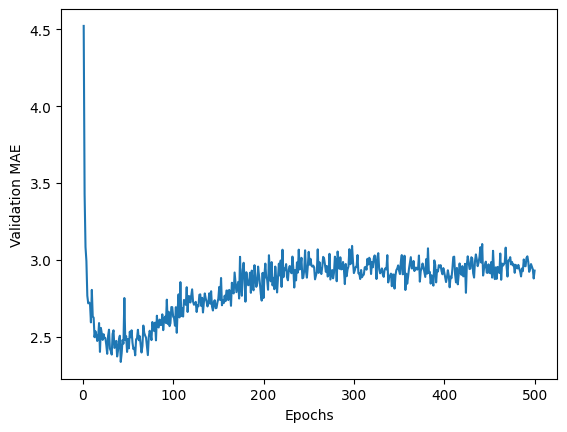

In [24]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

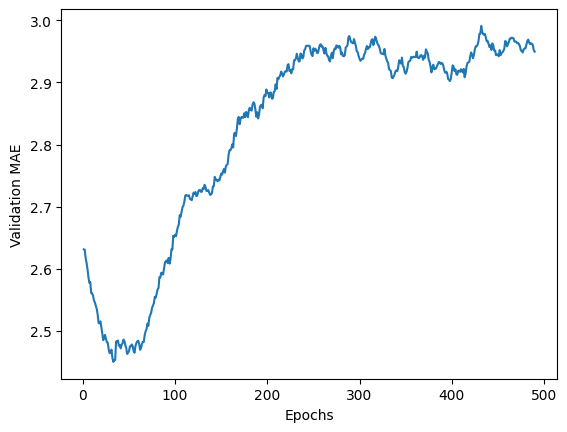

In [25]:
# use moving average to spline the noisy line
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# final model
Use optimized parameters and whole dataset

In [26]:

model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 4ms/step - loss: 19.7288 - mae: 2.7419


In [27]:
test_mae_score

2.7419447898864746

still showing 2.7K diff as a median housing value